# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.25

# Normalization factor
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Data tranformations
train_data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Load the train, validation and test data
train_data = datasets.ImageFolder(root="images/train", transform=train_data_transforms)
valid_data = datasets.ImageFolder(root="images/train", transform=data_transform)
test_data = datasets.ImageFolder(root="images/test", transform=data_transform)

# Class names/labels
classes = train_data.classes
print(f"There are {len(classes)} different classes.")

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

print(f"We have {len(train_sampler)} of training data.")
print(f"We have {len(valid_sampler)} of validation data.")
print(f"We have {len(test_data)} of test data.")

loaders_scratch = {
    'train': DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=True,
    ),
    'valid': DataLoader(
        valid_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
        pin_memory=True,
    ),
    'test': DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=num_workers,
    ),
}

There are 50 different classes.
We have 3747 of training data.
We have 1249 of validation data.
We have 1250 of test data.


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
* I chose and output tensor 224x224 for the image and I chose this because I think it is a reasonable size to identify the features on the images. It is also not too large to run on my local computer. In addition, the VVG16 model takes input images of 224x224 (I used this model in the 2nd exercise). I cropped the image using `RandomResizedCrop` since some images contains features we're not interested in (e.g. the sky or grass in the background).
* The training dataset is augmented with the following tranformations (from experimentation):
    1. Randomly flip images from dataset horizontally.
    2. Randomly rotate the images from data set by 15 degrees.
    3. Normalizing the RGB levels of all images.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_1893389/1760053023.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

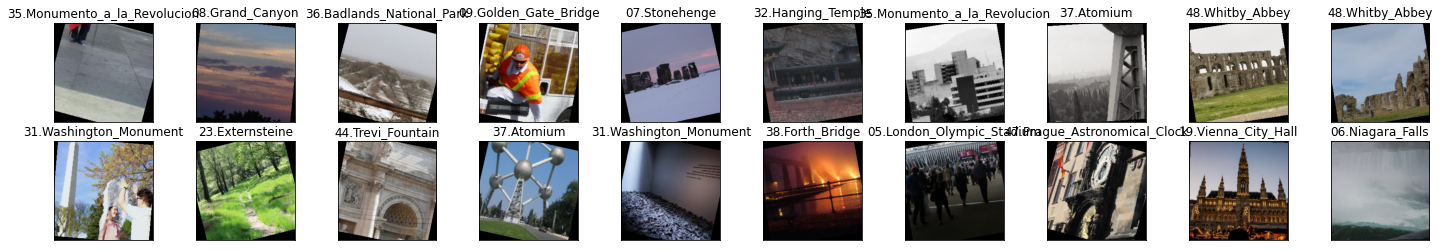

In [7]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)) * std + mean) # remove normalization for visualization
    ax.set_title(classes[int(labels[idx].numpy())])

### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [9]:
from torch import nn
from torch import optim

In [10]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model, learning_rate=0.01, momentum=0.0, weight_decay=0.0):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [11]:
import torch.nn.functional as F

In [12]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 50)
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        
        # Convolution layer
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))

        # 1st Dropout
        x = self.dropout(x)
        
        # Flatten image
        x = x.view(-1, 128*28*28)
        
        # 1st fully connected layer
        x = F.relu(self.fc1_bn(self.fc1(x)))
        
        # 2nd Dropout
        x = self.dropout(x)
        
        # 2nd fully connected layer
        x = F.relu(self.fc2_bn(self.fc2(x)))
        
        # 3rd Dropout
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
#     model_scratch.cuda()
    print("Moving Neural Net to GPU")
    model_scratch.to(torch.device("cuda:0"))

Moving Neural Net to GPU


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
* The above Neural Net model is the best I found to classify the landmark images. The model consists of the following:
    1. 2D Convolutions - in=3 -> out=32 with Batch Normalization then ReLU activation.
    2. Maxpooling with kernel size and stride (2,2).
    3. 2D Convolutions - in=32 -> out=64 with Batch Normalization then ReLU activation.
    4. Maxpooling with kernel size and stride (2,2).
    5. 2D Convolutions - in=64 -> out=128 with Batch Normalization then ReLU activation.
    6. Maxpooling with kernel size and stride (2,2).
    7. 25% dropout.
    8. Flatten image
    9. Pipeline to a fully connected layer of (128x26x26, 256) with Batch Normalization then ReLU activation
    10. 25% dropout.
    11. Pipeline to a fully connected layer of (256, 128) with ReLU Batch Normalization then ReLU activation
    10. 25% dropout.
    11. Output to a fully connected layer of (128, 50)
* For the convolution layer, I increased the channels from 32 to 128 to capture better features. Each convolution uses a kernel size of 3x3 with a padding of 1.
* Batch Normalizations are applied after every layer before ReLU activation. This improves convergence for the optimizer.
* I used dropout with a probability of 0.25 because I found that this improves the accuracy of the Neural Net.
* For the fully connected layer, I set the output channels to (256,128,50). I tried using (512,256,50) and found that my validation loss was progressively growing larger than the training loss indicating that my model is too complex causing overfitting.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, threshold=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # Clear any gradients
            optimizer.zero_grad()
            
            # Predict the image
            output = model(data)
            
            # Calculate the loss
            loss = criterion(output, target)
            
            # Back propagation
            loss.backward()
            
            # Optimize by 1 step
            optimizer.step()

            # Update training loss
            train_loss += 1 / (batch_idx + 1) * (loss.data.item() - train_loss)

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            
            # Predict the image
            output = model(data)
            
            # Calculate the loss
            loss = criterion(output, target)
            
            # Update the validation loss
            valid_loss += 1 / (batch_idx + 1) * (loss.data.item() - valid_loss)
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        # Early stopping
        if threshold is not None and valid_loss < threshold:
            print(f"Stopping training early, validation loss = {valid_loss} < {threshold}")
            break
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [14]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(
    20,
    loaders_scratch,
    model_scratch,
    get_optimizer_scratch(model_scratch, learning_rate=0.01, momentum=0.0, weight_decay=0.0),
    criterion_scratch, 
    use_cuda, 
    'ignore.pt',
)

Epoch: 1 	Training Loss: 3.876795 	Validation Loss: 3.779960
Validation loss decreased (inf --> 3.779960). Saving model ...
Epoch: 2 	Training Loss: 3.731397 	Validation Loss: 3.621684
Validation loss decreased (3.779960 --> 3.621684). Saving model ...
Epoch: 3 	Training Loss: 3.635563 	Validation Loss: 3.559253
Validation loss decreased (3.621684 --> 3.559253). Saving model ...
Epoch: 4 	Training Loss: 3.593598 	Validation Loss: 3.509980
Validation loss decreased (3.559253 --> 3.509980). Saving model ...
Epoch: 5 	Training Loss: 3.552811 	Validation Loss: 3.456151
Validation loss decreased (3.509980 --> 3.456151). Saving model ...
Epoch: 6 	Training Loss: 3.496130 	Validation Loss: 3.422246
Validation loss decreased (3.456151 --> 3.422246). Saving model ...
Epoch: 7 	Training Loss: 3.482674 	Validation Loss: 3.397783
Validation loss decreased (3.422246 --> 3.397783). Saving model ...
Epoch: 8 	Training Loss: 3.438356 	Validation Loss: 3.381124
Validation loss decreased (3.397783 --> 3

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [14]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(
    num_epochs,
    loaders_scratch,
    model_scratch,
    get_optimizer_scratch(model_scratch, learning_rate=0.01, momentum=0.0, weight_decay=0.0),
    criterion_scratch,
    use_cuda,
    'model_scratch.pt',
    threshold=2.0, # Stop training once validation loss is below 1.0
)

Epoch: 1 	Training Loss: 3.868165 	Validation Loss: 3.763678
Validation loss decreased (inf --> 3.763678). Saving model ...
Epoch: 2 	Training Loss: 3.715027 	Validation Loss: 3.598846
Validation loss decreased (3.763678 --> 3.598846). Saving model ...
Epoch: 3 	Training Loss: 3.643477 	Validation Loss: 3.497512
Validation loss decreased (3.598846 --> 3.497512). Saving model ...
Epoch: 4 	Training Loss: 3.594691 	Validation Loss: 3.468581
Validation loss decreased (3.497512 --> 3.468581). Saving model ...
Epoch: 5 	Training Loss: 3.543517 	Validation Loss: 3.426339
Validation loss decreased (3.468581 --> 3.426339). Saving model ...
Epoch: 6 	Training Loss: 3.504513 	Validation Loss: 3.380615
Validation loss decreased (3.426339 --> 3.380615). Saving model ...
Epoch: 7 	Training Loss: 3.461289 	Validation Loss: 3.348111
Validation loss decreased (3.380615 --> 3.348111). Saving model ...
Epoch: 8 	Training Loss: 3.429648 	Validation Loss: 3.335292
Validation loss decreased (3.348111 --> 3

Epoch: 90 	Training Loss: 2.351387 	Validation Loss: 2.668990
Epoch: 91 	Training Loss: 2.354758 	Validation Loss: 2.660644
Epoch: 92 	Training Loss: 2.368511 	Validation Loss: 2.456598
Epoch: 93 	Training Loss: 2.375706 	Validation Loss: 2.376799
Validation loss decreased (2.414998 --> 2.376799). Saving model ...
Epoch: 94 	Training Loss: 2.326791 	Validation Loss: 2.341918
Validation loss decreased (2.376799 --> 2.341918). Saving model ...
Epoch: 95 	Training Loss: 2.350087 	Validation Loss: 2.536049
Epoch: 96 	Training Loss: 2.297194 	Validation Loss: 2.514931
Epoch: 97 	Training Loss: 2.323223 	Validation Loss: 2.663335
Epoch: 98 	Training Loss: 2.330773 	Validation Loss: 2.343792
Epoch: 99 	Training Loss: 2.292437 	Validation Loss: 2.515715
Epoch: 100 	Training Loss: 2.308554 	Validation Loss: 2.395389


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [16]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.250758


Test Accuracy: 42% (532/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Reusing the loaders from the previous step.
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [19]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model, learning_rate=0.01, momentum=0.0, weight_decay=0.0):
    ## TODO: select and return an optimizer
    return optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
from torchvision import models

In [29]:
## TODO: Specify model architecture
model_transfer = models.vgg16(pretrained=True)

# Freeze training for feature layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Modify the last fully-connected layer
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
* I chose the VGG16 model because this model is known to give high accuracy for image classification.
* I froze all of the weights for the feature layers (i.e. convolution layers) and only retrain the last fully-connected layer to match the number of classes in my dataset (50 classes).

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 100

model_transfer = train(
    num_epochs,
    loaders_transfer,
    model_transfer,
    get_optimizer_transfer(model_transfer, learning_rate=0.01, momentum=0.0, weight_decay=0.0),
    criterion_transfer,
    use_cuda,
    'model_transfer.pt',
    threshold=1.0, # Stop training once validation loss is below 1.0
)

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.664944 	Validation Loss: 3.089300
Validation loss decreased (inf --> 3.089300). Saving model ...
Epoch: 2 	Training Loss: 2.986766 	Validation Loss: 2.403798
Validation loss decreased (3.089300 --> 2.403798). Saving model ...
Epoch: 3 	Training Loss: 2.465539 	Validation Loss: 1.949125
Validation loss decreased (2.403798 --> 1.949125). Saving model ...
Epoch: 4 	Training Loss: 2.151167 	Validation Loss: 1.711177
Validation loss decreased (1.949125 --> 1.711177). Saving model ...
Epoch: 5 	Training Loss: 1.978247 	Validation Loss: 1.586039
Validation loss decreased (1.711177 --> 1.586039). Saving model ...
Epoch: 6 	Training Loss: 1.821480 	Validation Loss: 1.449508
Validation loss decreased (1.586039 --> 1.449508). Saving model ...
Epoch: 7 	Training Loss: 1.764171 	Validation Loss: 1.410330
Validation loss decreased (1.449508 --> 1.410330). Saving model ...
Epoch: 8 	Training Loss: 1.696795 	Validation Loss: 1.353960
Validation loss decreased (1.410330 --> 1

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.914941


Test Accuracy: 74% (935/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [32]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(model, classes, img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # Process image
    pil_image = Image.open(img_path)
    new_img = pil_image.resize((224,224))

    np_image = np.array(new_img)/224
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean)/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    # Run through Neural Net
    tensor_img = torch.FloatTensor([np_image]).cuda()
    result = model(tensor_img).topk(k)
    
    idx = result[1].data.cpu().numpy()[0]
    
    predicted_labels = [classes[i] for i in idx]
    
    return predicted_labels

# test on a sample image
predict_landmarks(model_transfer, classes, 'images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

/tmp/ipykernel_1851162/519194944.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/torch/csrc/utils/tensor_new.cpp:201.)
  tensor_img = torch.FloatTensor([np_image]).cuda()


['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '30.Brooklyn_Bridge',
 '28.Sydney_Harbour_Bridge',
 '33.Sydney_Opera_House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

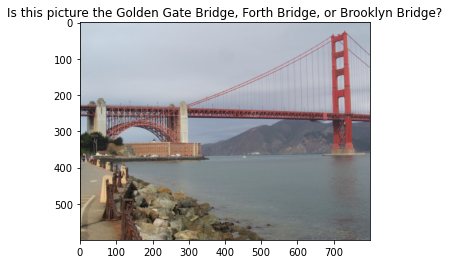

In [33]:
def suggest_locations(model, classes, img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(model, classes, img_path, 3)
    predicted_landmarks = [landmark.split(".")[-1] for landmark in predicted_landmarks]
    predicted_landmarks = [" ".join(landmark.split("_")) for landmark in predicted_landmarks]
    
    ## TODO: display image and display landmark predictions
    fig, ax = plt.subplots()
    
    pil_image = Image.open(img_path)
    
    ax.imshow(pil_image)
    ax.set_title(
        f"Is this picture the {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?"
    )

# test on a sample image
suggest_locations(model_transfer, classes, 'images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
* For the four examples below, I think the model predicts the picture moderately. 
* Three points for improvement:
    1. Increase number of epochs until validation loss is below a lower threshold (e.g. 0.5).
    2. Retrain the 2nd last and/or 3rd last fully-connecting layer.
    3. Increase the training data.
    4. Try a model with deeper layer like the VGG19 or other models like Microsoft's ResNet or Google's GoogLeNet.

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

### 01 - Ljubljana Castle

* from **test set**

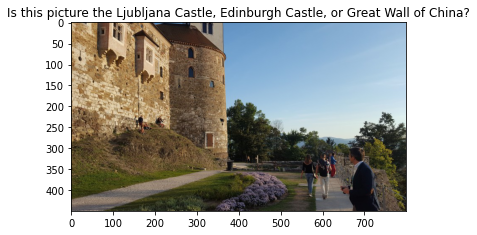

In [34]:
suggest_locations(model_transfer, classes, 'images/test/02.Ljubljana_Castle/00a5e433e69eddc0.jpg')

* from the Internet

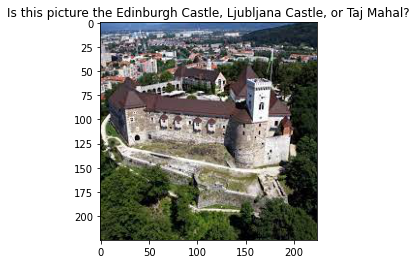

In [35]:
suggest_locations(model_transfer, classes, 'my_images/ljubljana_castle.jpeg')

### 02 - Mount Rushmore

* from **test set**

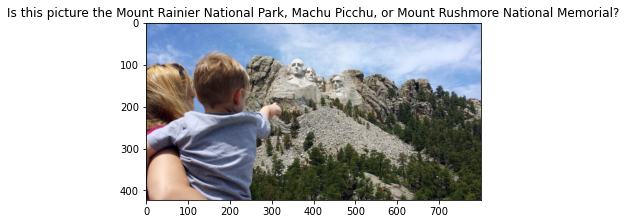

In [36]:
suggest_locations(model_transfer, classes, 'images/test/11.Mount_Rushmore_National_Memorial/5d05b0fe0b7bae19.jpg')

* from the Internet

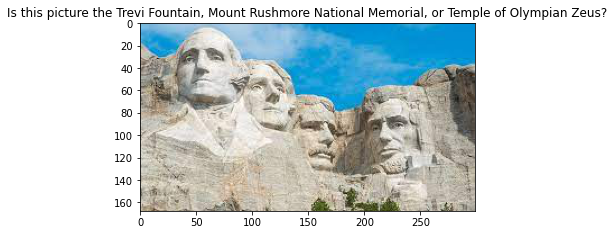

In [37]:
suggest_locations(model_transfer, classes, 'my_images/mount_rushmore.jpeg')

### 03 - Hanging Temple

* from **test set**

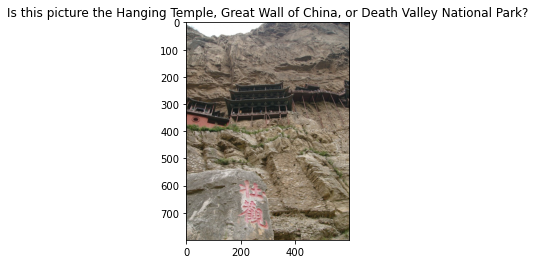

In [38]:
suggest_locations(model_transfer, classes, 'images/test/32.Hanging_Temple/2be0796ef2e0cc49.jpg')

* from the Internet

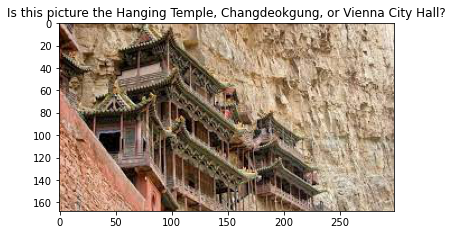

In [39]:
suggest_locations(model_transfer, classes, 'my_images/hanging_temple.jpeg')

### 04 - Great Barrier Reef

* from **test set**

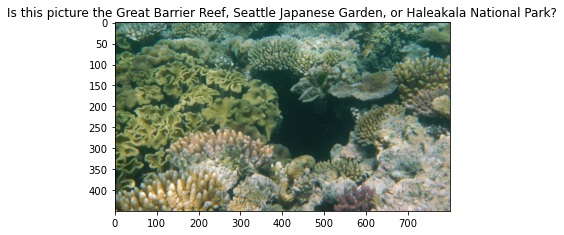

In [40]:
suggest_locations(model_transfer, classes, 'images/test/34.Great_Barrier_Reef/755b53f451b9ffbc.jpg')

* from the Internet

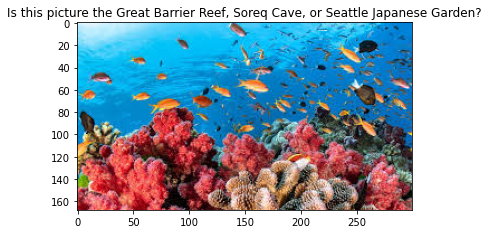

In [41]:
suggest_locations(model_transfer, classes, 'my_images/great_barrier_reef.jpeg')

### 05 - Terminal Tower

* from the **test set**

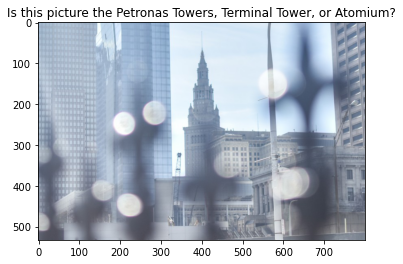

In [42]:
suggest_locations(model_transfer, classes, 'images/test/14.Terminal_Tower/3882be5e9b209e45.jpg')

* from the internet

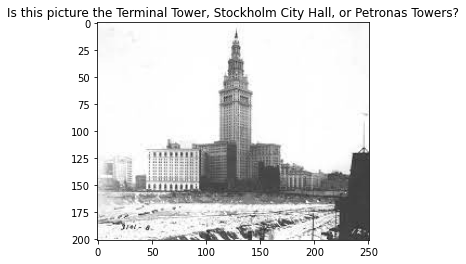

In [43]:
suggest_locations(model_transfer, classes, 'my_images/terminal_tower.jpeg')